In [1]:
import sys, os, pickle
sys.path.append('/scratch/oem214/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import *
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt

In [2]:
task = Flip_Flop_Task(3, 0.05, input_magnitudes=None)
N_train = 20000
N_test = 1000
checkpoint_interval = 10
sigma = 0

data = task.gen_data(N_train, N_test)

n_in = task.n_in
n_hidden = 32
n_out = task.n_out
W_in  = np.random.normal(0, np.sqrt(1/(n_in)), (n_hidden, n_in))
W_rec = np.random.normal(0, np.sqrt(1/n_hidden), (n_hidden, n_hidden))
W_out = np.random.normal(0, np.sqrt(1/(n_hidden)), (n_out, n_hidden))

b_rec = np.zeros(n_hidden)
b_out = np.zeros(n_out)

alpha = 1
sigma = 0

rnn = RNN(W_in, W_rec, W_out, b_rec, b_out,
          activation=tanh,
          alpha=alpha,
          output=identity,
          loss=mean_squared_error)

learn_alg = RFLO(rnn, alpha=alpha, L2_reg=0.0001, L1_reg=0.0001)
optimizer = SGD_Momentum(lr=0.01, mu=0.6)

monitors = []

sim = Simulation(rnn)
sim.run(data, learn_alg=learn_alg, optimizer=optimizer,
        sigma=sigma,
        monitors=monitors,
        verbose=True,
        report_accuracy=False,
        report_loss=True,
        checkpoint_interval=checkpoint_interval,
        checkpoint_optimizer=False)

Progress: 10.0% complete 
Time Elapsed: 0.5s 
Test loss: 0.5148510398884386 

Progress: 20.0% complete 
Time Elapsed: 1.1s 
Test loss: 0.26271312986455636 

Progress: 30.0% complete 
Time Elapsed: 1.6s 
Test loss: 0.15339142429366356 

Progress: 40.0% complete 
Time Elapsed: 2.2s 
Test loss: 0.046194178114879296 

Progress: 50.0% complete 
Time Elapsed: 2.7s 
Test loss: 0.018976873597572226 

Progress: 60.0% complete 
Time Elapsed: 3.3s 
Test loss: 0.023473220035175782 

Progress: 70.0% complete 
Time Elapsed: 3.8s 
Test loss: 0.018913508274487466 

Progress: 80.0% complete 
Time Elapsed: 4.4s 
Test loss: 0.007577969202802845 

Progress: 90.0% complete 
Time Elapsed: 4.9s 
Test loss: 0.006556259701747983 



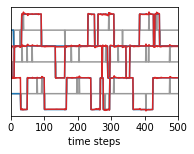

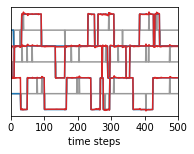

In [3]:
#Plot final checkpoint results
data = task.gen_data(0, 500)
plot_output_from_checkpoint(sim.checkpoints[sorted(sim.checkpoints.keys())[-1]], data)

In [ ]:
file_name = 'rflo_anecdote'

In [ ]:
### --- SAVE RUN --- ###
with open(os.path.join('saved_runs/', file_name), 'wb') as f:
    saved_run = {'sim': sim, 'task': task}
    pickle.dump(saved_run, f)

In [ ]:
### --- OPEN RUN --- ###
with open(os.path.join('saved_runs/', file_name), 'rb') as f:
    saved_run = pickle.load(f)
    sim = saved_run['sim']
    task =saved_run['task']

In [ ]:
### --- Default topological analysis --- ###
topological_analysis(file_name, FP_KE_criterion=0.00001, FP_N=800, ppn=16, compare_n_comp_window=1)

In [ ]:
### -- Include geometry --- ###
topological_analysis(file_name, FP_find_FPs=True, FP_KE_criterion=0.00001, FP_N=800,
                     compare_align_checkpoints=True, compare_aligned_graph=True,
                     compare_n_comp_window=1,
                     test_N=2000, test_save_data=True, compare_CKA=False,
                     compare_PC1=False, compare_PC2=True, compare_PC3=False)

In [ ]:
###Get job status
get_ipython().system('squeue -u oem214')

In [ ]:
file_name = 'job_name'
saved_run_name = file_name
analysis_job_name = 'analyze_{}'.format(saved_run_name)
compare_job_name = 'compare_{}'.format(saved_run_name)

results_dir = '/scratch/oem214/learning-dynamics/results/'

analysis_result_path = os.path.join(results_dir, analysis_job_name)
indices, checkpoints = unpack_analysis_results(analysis_result_path)
signals = unpack_compare_result(file_name, checkpoint_stats={'test_loss': get_checkpoint_loss})

In [ ]:
fig = plot_signals(signals, x_values=indices, signal_clips={})

In [ ]:
plot_kinetic_energy_histograms(indices, checkpoints, red_line=-5)

In [ ]:
checkpoint_1 = checkpoints['checkpoint_19000']
checkpoint_2 = checkpoints['checkpoint_10100']
plot_input_dependent_topology(checkpoint_1)